## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Mollusca - Zo </h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)
    * [5.1 MobileNetV2](#MobileNetV2)
    * [5.2 EfficientNetB0](#EfficientNetB0)
    * [5.3 Hyperparameter Tuning for MobileNetV2](#hptMobileNetV2)
    * [5.4 Test MobileNetV2](#testMobileNetV2)

# 1. Introduction <a class="anchor" id="intro"></a>

In this third notebook, we will preprocess images from the **Mollusca** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from sklearn.metrics import confusion_matrix

import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, smart_resize
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Libraries for image processing
from glob import glob
from PIL import Image

2025-04-09 21:06:59.617228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Mollusca Phylum.

In [2]:
# Load the DataFrame from the CSV file
mollusca_train = pd.read_csv("train_test_splits/Mollusca_train.csv")
mollusca_train.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,30003937,46473744,animalia,mollusca,cardiidae,mollusca_cardiidae/30003937_46473744_eol-full-...
1,2744855,449459,animalia,mollusca,unionidae,mollusca_unionidae/2744855_449459_eol-full-siz...
2,12835846,46454284,animalia,mollusca,conidae,mollusca_conidae/12835846_46454284_eol-full-si...


In [3]:
# Load the DataFrame from the CSV file
mollusca_test = pd.read_csv("train_test_splits/Mollusca_test.csv")
mollusca_test.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,22271558,46454284,animalia,mollusca,conidae,mollusca_conidae/22271558_46454284_eol-full-si...
1,12800653,4792502,animalia,mollusca,haliotidae,mollusca_haliotidae/12800653_4792502_eol-full-...
2,13998439,46473744,animalia,mollusca,cardiidae,mollusca_cardiidae/13998439_46473744_eol-full-...


In [4]:
mollusca_train['family'].value_counts()

family
cardiidae     48
unionidae     39
conidae       24
haliotidae    24
zonitidae     24
Name: count, dtype: int64

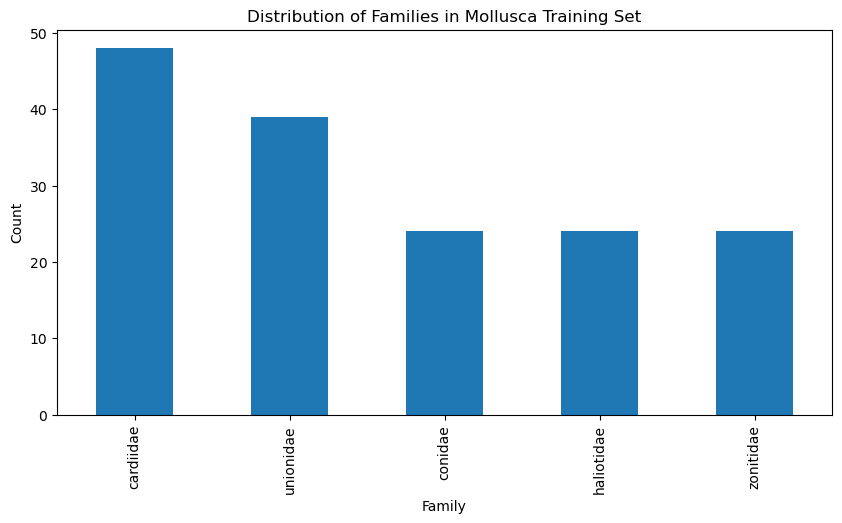

In [5]:
mollusca_train['family'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Families in Mollusca Training Set')
plt.xlabel('Family')
plt.ylabel('Count')
plt.show()

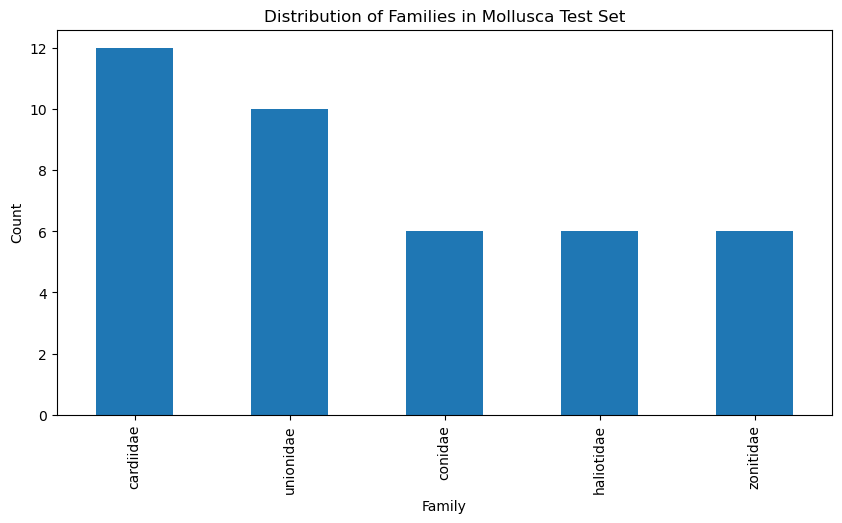

In [6]:
mollusca_test['family'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Families in Mollusca Test Set')
plt.xlabel('Family')
plt.ylabel('Count')
plt.show()

In [7]:
mollusca_train.shape, mollusca_test.shape

((159, 6), (40, 6))

In [8]:
print(mollusca_train['file_path'].iloc[0])
os.path.exists(mollusca_train['file_path'].iloc[0])

mollusca_cardiidae/30003937_46473744_eol-full-size-copy.jpg


False

# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

In [5]:
# Resize all images to a fixed size (for consistent input to model)
IMAGE_SIZE = (128, 128)  # Will use 128x128 for faster training and less overfitting (according to chatGPT) since the dataset is small 
BATCH_SIZE = 16  # Number of images loaded per batch (for training) try 8 next time for better generalization but longer training time

# Directory where the images are stored
image_root_dir = os.path.join("rare_species")

# Prepend full image path to each file_path
mollusca_train['filepath'] = mollusca_train['file_path'].apply(lambda x: os.path.join(image_root_dir, x))
mollusca_test['filepath'] = mollusca_test['file_path'].apply(lambda x: os.path.join(image_root_dir, x))

# ---------------------------------------------------
# Data generator for TRAINING images (includes augmentation)
# ---------------------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,            # Normalize pixel values from [0, 255] → [0, 1]
    rotation_range=15,         # Randomly rotate images by up to 15 degrees (can try 30 next time)
    zoom_range=0.1,            # Random zoom inside image (10%) (can try 0.2 next time)
    horizontal_flip=True,      # Randomly flip images horizontally (like mirror view)
    validation_split=0.2       # Reserve 20% of training data for validation (done via 'subset' below)
)

# ---------------------------------------------------
# Data generator for TEST images (no augmentation)
# ---------------------------------------------------
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255  # Only rescaling, no augmentation on test set
)

# ---------------------------------------------------
# TRAINING generator – loads 80% of training images with augmentation
# ---------------------------------------------------
train_generator = train_datagen.flow_from_dataframe(
    dataframe=mollusca_train,         # DataFrame with image filepaths and labels
    x_col='filepath',                 # Column with full path to images
    y_col='family',                   # Column with class labels (family)
    target_size=IMAGE_SIZE,           # Resize all images to this size
    class_mode='categorical',         # One-hot encode class labels
    batch_size=BATCH_SIZE,            # Load this many images per batch
    subset='training',                # Use the training subset (80%)
    shuffle=True,                     # Shuffle the data for training
    seed=4                            # For reproducibility
)

# ---------------------------------------------------
# VALIDATION generator – loads 20% of training images with same preprocessing
# ---------------------------------------------------
val_generator = train_datagen.flow_from_dataframe(
    dataframe=mollusca_train,
    x_col='filepath',
    y_col='family',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation',             # Use the validation subset (20%)
    shuffle=True,                    # Shuffle again (optional for validation)
    seed=4
)

# ---------------------------------------------------
# TEST generator – loads test data (no augmentation, no subset split)
# ---------------------------------------------------
test_generator = test_datagen.flow_from_dataframe(
    dataframe=mollusca_test,
    x_col='filepath',
    y_col='family',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=1,                    # Usually 1 for predictions/evaluation
    shuffle=False                    # Do not shuffle so predictions align with input order
)


Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


Found 5 validated image filenames.


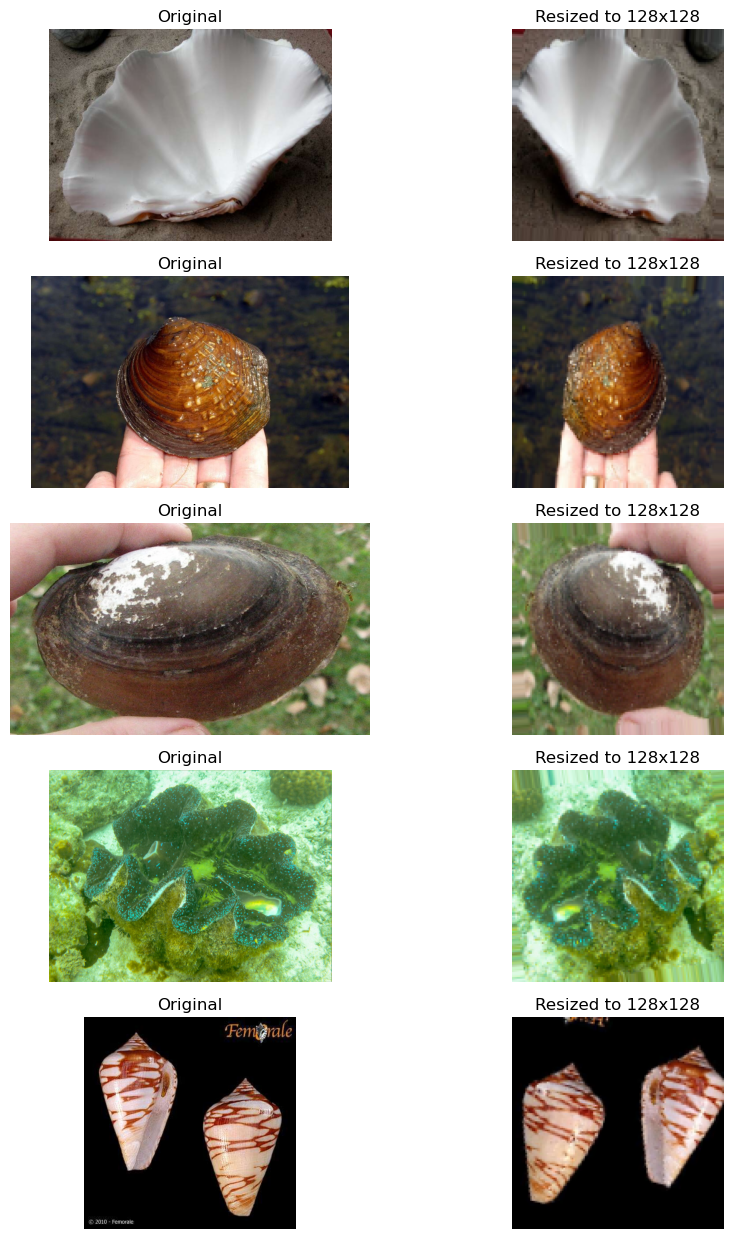

In [10]:
def visualize_pipeline_resize(df, generator, image_size=(128, 128), num_samples=5):
    """
    Shows side-by-side comparison of original vs resized (via generator) images.
    - df: DataFrame with 'filepath' column
    - generator: the ImageDataGenerator used with flow_from_dataframe
    - image_size: the target size used in the generator
    """
    sample_df = df.sample(n=num_samples, random_state=42).reset_index(drop=True)

    # Create a preview generator (use the same one as your train_generator)
    preview_generator = generator.flow_from_dataframe(
        dataframe=sample_df,
        x_col='filepath',
        y_col=None,
        class_mode=None,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    plt.figure(figsize=(10, num_samples * 2.5))

    for i in range(num_samples):
        # ORIGINAL
        original = load_img(sample_df.loc[i, 'filepath'])
        
        # PIPELINE-RESIZED
        resized = next(preview_generator)[0]

        # Plot original
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis('off')

        # Plot resized
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(resized)
        plt.title(f"Resized to {image_size[0]}x{image_size[1]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the resizing pipeline
visualize_pipeline_resize(mollusca_train, train_datagen, image_size=IMAGE_SIZE, num_samples=5)

# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

## 5.1. MobileNetV2 <a class="anchor" id="MobileNetV2"></a>

In [11]:
# Load base model without top layer
base_model = MobileNetV2(
    input_shape=(128, 128, 3),  # Match your resized image shape
    include_top=False,         # Don't include the original classifier
    weights='imagenet'         # Use ImageNet-pretrained weights
)

# Freeze base model so we only train the new layers for now
base_model.trainable = False

# Build custom model
model = models.Sequential([
    base_model,                                # Feature extractor
    layers.GlobalAveragePooling2D(),           # Pool over spatial dimensions
    layers.Dropout(0.3),                       # Regularization layer
    layers.Dense(128, activation='relu'),      # Fully connected layer
    layers.Dense(5, activation='softmax')      # Output layer (5 mollusk families)
])

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary for your viewing pleasure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2422597 (9.24 MB)
Trainable params: 164613

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,           # Start small, increase if needed
    verbose=1
)
# Execution time: 9m 58.2s

Epoch 1/50
2/8 [======>.......................] - ETA: 3s - loss: 2.4392 - accuracy: 0.1250  

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 21s 2s/step - loss: 2.2046 - accuracy: 0.1406 - val_loss: 1.5506 - val_accuracy: 0.3548
Epoch 2/50
8/8 [==============================] - 10s 1s/step - loss: 1.6861 - accuracy: 0.3359 - val_loss: 1.3334 - val_accuracy: 0.4516
Epoch 3/50
8/8 [==============================] - 9s 1s/step - loss: 1.4540 - accuracy: 0.4375 - val_loss: 1.0636 - val_accuracy: 0.7097
Epoch 4/50
8/8 [==============================] - 9s 1s/step - loss: 1.2799 - accuracy: 0.5000 - val_loss: 0.9927 - val_accuracy: 0.6452
Epoch 5/50
8/8 [==============================] - 12s 1s/step - loss: 1.1318 - accuracy: 0.6094 - val_loss: 0.8417 - val_accuracy: 0.7419
Epoch 6/50
8/8 [==============================] - 12s 2s/step - loss: 0.9364 - accuracy: 0.6797 - val_loss: 0.7214 - val_accuracy: 0.7419
Epoch 7/50
8/8 [==============================] - 12s 2s/step - loss: 0.8597 - accuracy: 0.6875 - val_loss: 0.6166 - val_accuracy: 0.8065
Epoch 8/50
8/8 [==============================]

In [26]:
# Save the model
model.save('mollusca_classifier.h5')

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


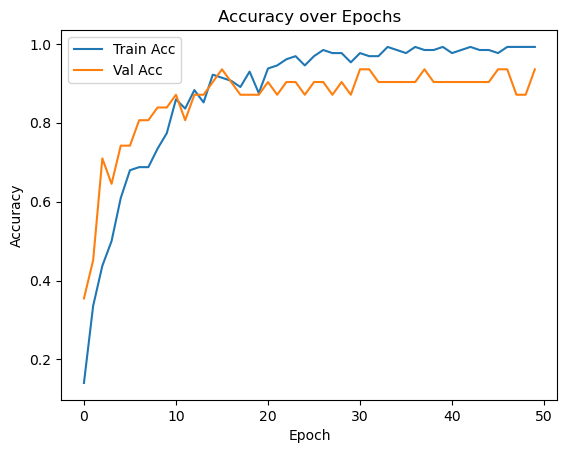

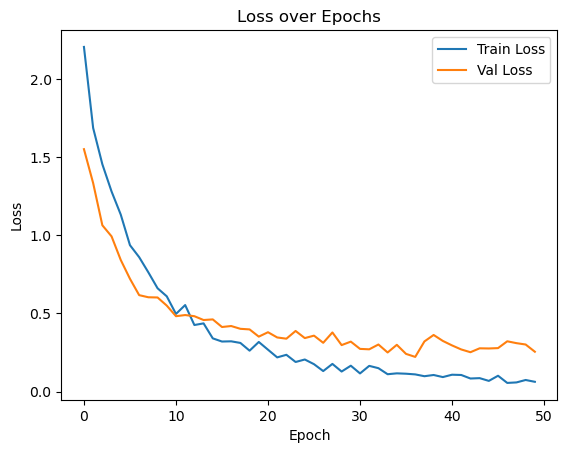

In [13]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

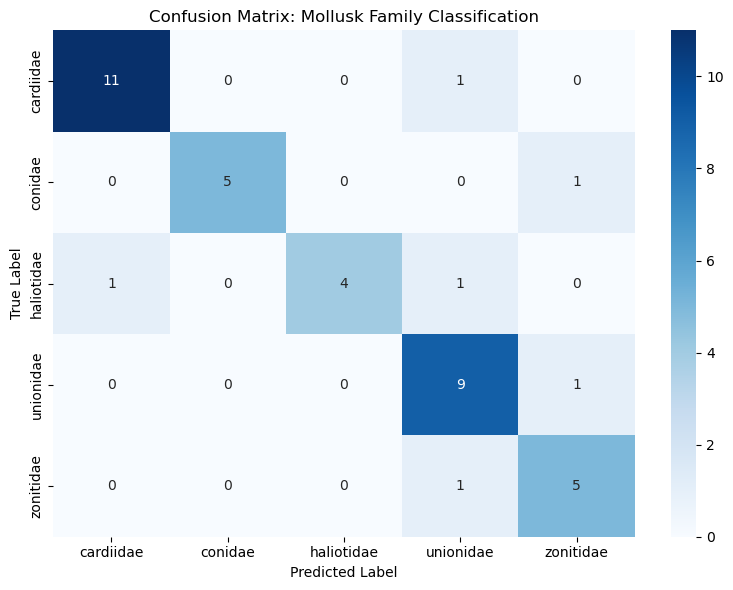

In [14]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 5.2. EfficientNetB0 <a class="anchor" id="EfficientNetB0"></a>

In [17]:
# Load EfficientNetB0 without the top classification layer
base_model = EfficientNetB0(
    input_shape=(128, 128, 3),   # Matches your resized images
    include_top=False,           # Remove the original classifier head
    weights='imagenet'           # Use pre-trained ImageNet weights
)

# Freeze the base model to use it as a fixed feature extractor
base_model.trainable = False

# Build your custom classifier head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 mollusk families
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of your EfficientNetB0 mollusk whisperer
model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                       

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    verbose=1
)
# Ececution time: 5m 17.2s

Epoch 1/25
3/8 [==========>...................] - ETA: 4s - loss: 1.6738 - accuracy: 0.1250

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 31s 2s/step - loss: 1.6230 - accuracy: 0.1719 - val_loss: 1.6342 - val_accuracy: 0.2581
Epoch 2/25
8/8 [==============================] - 13s 2s/step - loss: 1.5617 - accuracy: 0.2969 - val_loss: 1.7040 - val_accuracy: 0.2581
Epoch 3/25
8/8 [==============================] - 13s 2s/step - loss: 1.5506 - accuracy: 0.3125 - val_loss: 1.7322 - val_accuracy: 0.2581
Epoch 4/25
8/8 [==============================] - 12s 1s/step - loss: 1.5725 - accuracy: 0.2578 - val_loss: 1.7308 - val_accuracy: 0.2581
Epoch 5/25
8/8 [==============================] - 13s 2s/step - loss: 1.5819 - accuracy: 0.2812 - val_loss: 1.7081 - val_accuracy: 0.2581
Epoch 6/25
8/8 [==============================] - 12s 1s/step - loss: 1.5559 - accuracy: 0.2969 - val_loss: 1.7106 - val_accuracy: 0.2581
Epoch 7/25
8/8 [==============================] - 9s 1s/step - loss: 1.5589 - accuracy: 0.3359 - val_loss: 1.7102 - val_accuracy: 0.2581
Epoch 8/25
8/8 [==============================

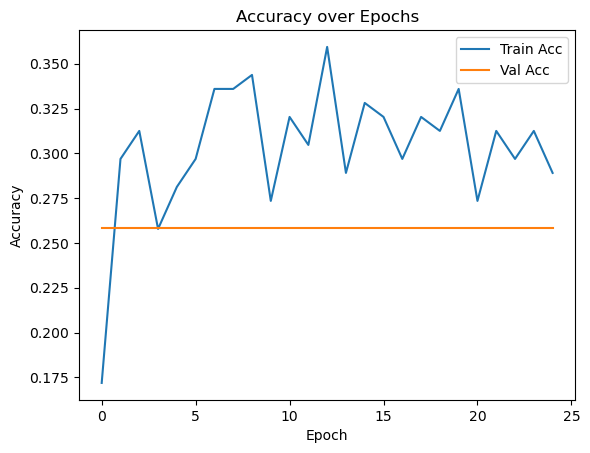

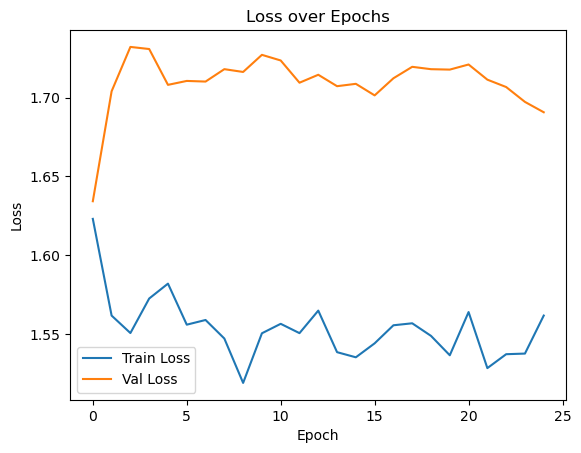

In [19]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

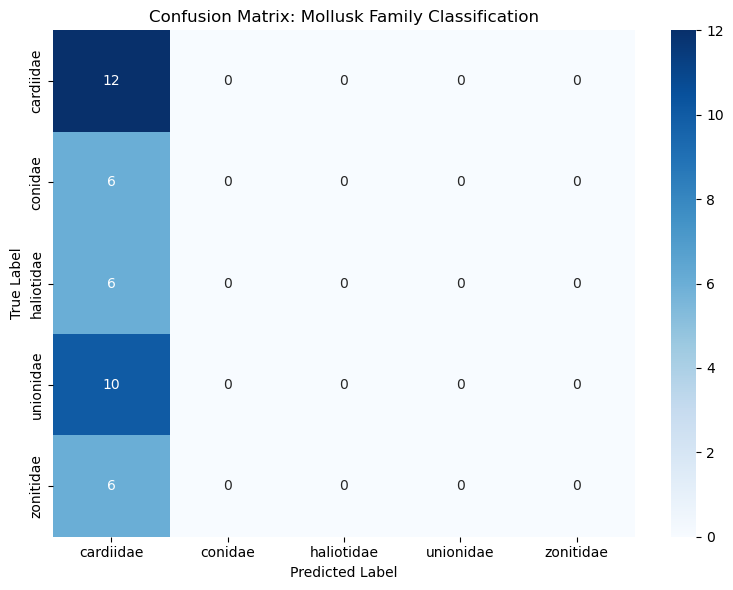

In [20]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 5.3. Hyperparameter tuning for MobileNetV2<a class="anchor" id="hptMobileNetV2"></a>

In [ ]:
# Define grid
optimizers_list = ['adam', 'rmsprop', 'sgd']
learning_rates = [1e-3, 1e-4, 1e-5]
dropouts = [0.2, 0.3, 0.4, 0.5]
dense_units = [64, 128, 256]
unfreeze_depths = [25, 50, 75]

# Create all combinations
all_combinations = list(itertools.product(optimizers_list, learning_rates, dropouts, dense_units, unfreeze_depths))

# Shuffle and sample a manageable batch (e.g., 40 combos)
random.seed(4)
sampled_combos = random.sample(all_combinations, k=40)

results = []

for i, (opt_name, lr, dropout, units, unfreeze) in enumerate(sampled_combos):
    print(f"\n🔥 Combo {i+1}/{len(sampled_combos)}: optimizer={opt_name}, lr={lr}, dropout={dropout}, units={units}, unfreeze={unfreeze}")

    # Load base model fresh
    base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = True
    fine_tune_at = len(base_model.layers) - unfreeze
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Build model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout),
        layers.Dense(units, activation='relu'),
        layers.Dense(5, activation='softmax')
    ])

    # Choose optimizer
    if opt_name == 'adam':
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_name == 'rmsprop':
        opt = optimizers.RMSprop(learning_rate=lr)
    elif opt_name == 'sgd':
        opt = optimizers.SGD(learning_rate=lr, momentum=0.9)

    # Compile
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=0
    )

    # Save best validation accuracy
    val_acc = max(history.history['val_accuracy'])
    print(f"✅ Validation Accuracy: {val_acc:.4f}")

    results.append({
        'optimizer': opt_name,
        'lr': lr,
        'dropout': dropout,
        'units': units,
        'unfreeze': unfreeze,
        'val_acc': val_acc
    })

# Show best configs
df_results = pd.DataFrame(results).sort_values(by='val_acc', ascending=False)
print("\n🏆 Top Configs:")
print(df_results.head(10))

# Time of execution: 103m 51.7s


🔥 Combo 1/40: optimizer=rmsprop, lr=0.001, dropout=0.3, units=128, unfreeze=25
✅ Validation Accuracy: 0.8387

🔥 Combo 2/40: optimizer=rmsprop, lr=0.0001, dropout=0.3, units=64, unfreeze=75
✅ Validation Accuracy: 0.9355

🔥 Combo 3/40: optimizer=adam, lr=0.0001, dropout=0.3, units=256, unfreeze=50
✅ Validation Accuracy: 0.9032

🔥 Combo 4/40: optimizer=rmsprop, lr=1e-05, dropout=0.4, units=128, unfreeze=50
✅ Validation Accuracy: 0.8710

🔥 Combo 5/40: optimizer=sgd, lr=0.001, dropout=0.5, units=64, unfreeze=75
✅ Validation Accuracy: 0.9032

🔥 Combo 6/40: optimizer=adam, lr=1e-05, dropout=0.2, units=256, unfreeze=50
✅ Validation Accuracy: 0.8387

🔥 Combo 7/40: optimizer=adam, lr=0.0001, dropout=0.3, units=64, unfreeze=50
✅ Validation Accuracy: 0.9032

🔥 Combo 8/40: optimizer=adam, lr=0.001, dropout=0.5, units=256, unfreeze=50
✅ Validation Accuracy: 0.6452

🔥 Combo 9/40: optimizer=adam, lr=0.001, dropout=0.3, units=64, unfreeze=50
✅ Validation Accuracy: 0.8387

🔥 Combo 10/40: optimizer=rmsp

In [7]:
# Load base model without top layer
base_model = MobileNetV2(
    input_shape=(128, 128, 3),   # Match your resized image shape
    include_top=False,           # Don't include the original classifier
    weights='imagenet'           # Use ImageNet-pretrained weights
)

# Fine-tune last 50 layers only
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Build custom model with best hyperparameters
model = models.Sequential([
    base_model,                                 # Feature extractor
    layers.GlobalAveragePooling2D(),            # Pool over spatial dimensions
    layers.Dropout(0.2),                        # Best regularization dropout
    layers.Dense(128, activation='relu'),       # Best number of units
    layers.Dense(5, activation='softmax')       # Output layer for 5 mollusk families
])

# Compile model with best optimizer and learning rate
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),  # Best optimizer + LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary for your viewing pleasure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2422597 (9.24 MB)
Trainable params: 201971

In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 36s 2s/step - loss: 1.3351 - accuracy: 0.5234 - val_loss: 0.9298 - val_accuracy: 0.6129
Epoch 2/50
8/8 [==============================] - 14s 2s/step - loss: 0.4908 - accuracy: 0.8828 - val_loss: 0.6163 - val_accuracy: 0.7419
Epoch 3/50
8/8 [==============================] - 14s 2s/step - loss: 0.3620 - accuracy: 0.9141 - val_loss: 0.5527 - val_accuracy: 0.7742
Epoch 4/50
8/8 [==============================] - 19s 2s/step - loss: 0.2564 - accuracy: 0.9297 - val_loss: 0.5154 - val_accuracy: 0.7742
Epoch 5/50
8/8 [==============================] - 16s 2s/step - loss: 0.1706 - accuracy: 0.9844 - val_loss: 0.3803 - val_accuracy: 0.9032
Epoch 6/50
8/8 [==============================] - 16s 2s/step - loss: 0.0947 - accuracy: 1.0000 - val_loss: 0.3484 - val_accuracy: 0.9032
Epoch 7/50
8/8 [==============================] - 19s 3s/step - loss: 0.0731 - accuracy: 0.9922 - val_loss: 0.2435 - val_accuracy: 0.9355
Epoch 8/50
8/8 [=============================

In [10]:
# Save the model
model.save('mollusca_classifier_new.h5')

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 5.4. Test MobileNetV2 <a class="anchor" id="testMobileNetV2"></a>

40/40 [==============================] - 12s 161ms/step - loss: 1.7303 - accuracy: 0.6500

✅ Test Accuracy: 0.6500
40/40 [==============================] - 12s 159ms/step

📋 Classification Report:
              precision    recall  f1-score   support

   cardiidae       0.89      0.67      0.76        12
     conidae       1.00      0.50      0.67         6
  haliotidae       0.50      0.50      0.50         6
   unionidae       0.47      0.90      0.62        10
   zonitidae       1.00      0.50      0.67         6

    accuracy                           0.65        40
   macro avg       0.77      0.61      0.64        40
weighted avg       0.76      0.65      0.66        40



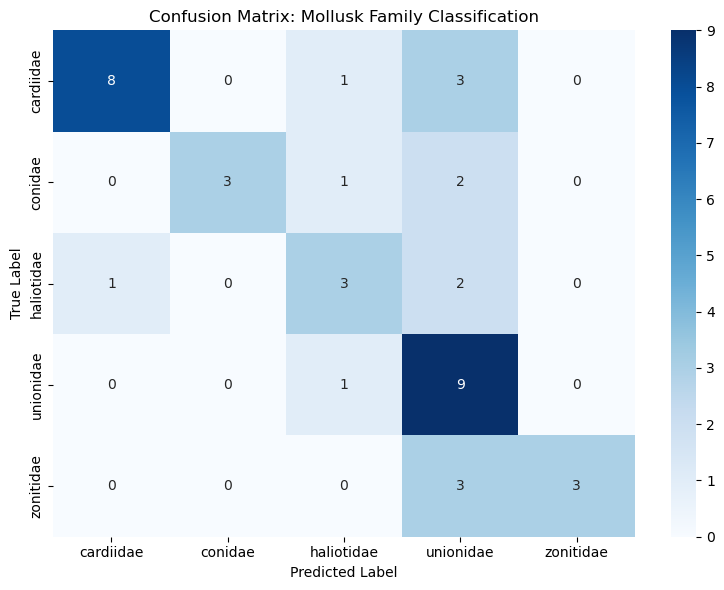

In [6]:
# Load your trained model
model = load_model("mollusca_classifier.h5")

# Evaluate on the test generator
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# Predict class probabilities
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


40/40 [==============================] - 4s 57ms/step - loss: 0.4362 - accuracy: 0.9250

✅ Test Accuracy: 0.9250
40/40 [==============================] - 4s 65ms/step

📋 Classification Report:
              precision    recall  f1-score   support

   cardiidae       0.86      1.00      0.92        12
     conidae       1.00      1.00      1.00         6
  haliotidae       1.00      0.83      0.91         6
   unionidae       0.91      1.00      0.95        10
   zonitidae       1.00      0.67      0.80         6

    accuracy                           0.93        40
   macro avg       0.95      0.90      0.92        40
weighted avg       0.93      0.93      0.92        40



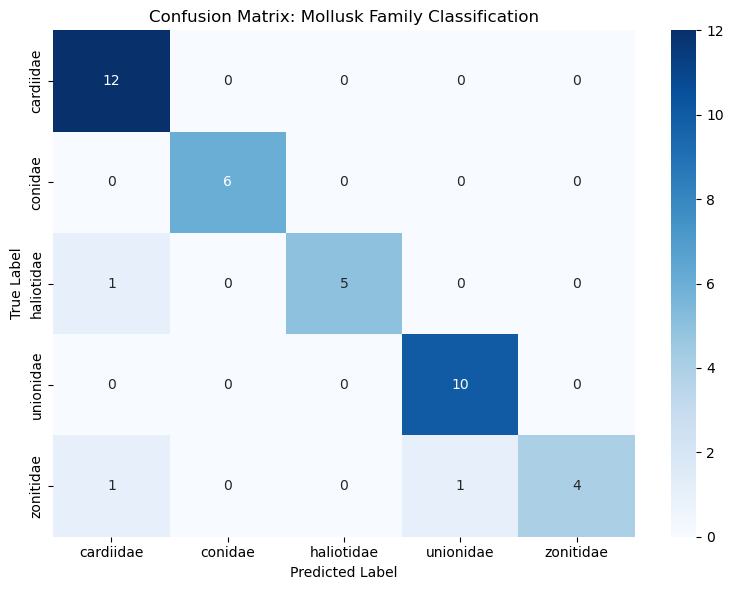

In [11]:
# Load your trained model
model = load_model("mollusca_classifier_new.h5")

# Evaluate on the test generator
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# Predict class probabilities
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

##### Print the misclassified images

🔍 Found 3 misclassified images.


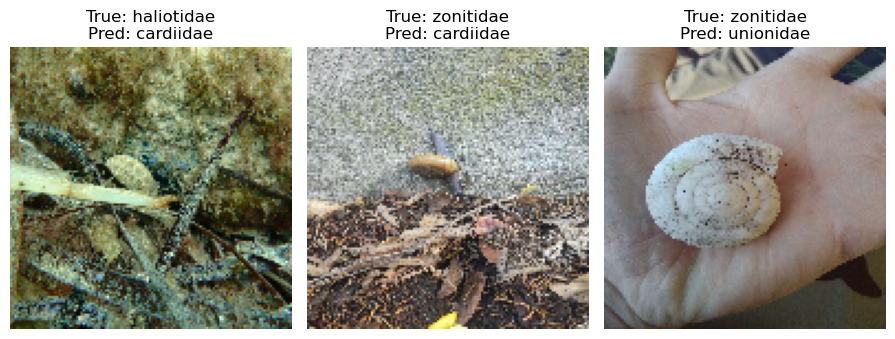

In [13]:
# 1. Get predictions
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# 2. Get misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]

print(f"🔍 Found {len(misclassified_indices)} misclassified images.")

# 3. Plot a few misclassified images
num_to_plot = min(10, len(misclassified_indices))  # Limit to 10 for visualization

plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_indices[:num_to_plot]):
    img_path = mollusca_test.iloc[idx]['filepath']
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0  # Normalize for display

    plt.subplot(2, 5, i+1)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")

plt.tight_layout()
plt.show()
